# Kурс Open Data Science

### Соревнование ["Catch Me If You Can: Intruder Detection through Webpage Session Tracking"](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking)

#### Подрезов Антон 
(часть кода взята из домашних работ курса ODS, часть из открытых источников с указанием ссылок, часть дописана самостоятельно)

In [1]:
from __future__ import division, print_function

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import TfidfVectorizer

## 1. Загрузка и преобразование данных

In [2]:
# загрузим обучающую и тестовую выборки
train_df = pd.read_csv('../../data/websites_train_sessions.csv', index_col='session_id')
test_df = pd.read_csv('../../data/websites_test_sessions.csv', index_col='session_id')

# приведем колонки time1, ..., time10 к временному формату
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# отсортируем данные по времени
train_df = train_df.sort_values(by='time1')

# приведем колонки site1, ..., site10 к целочисленному формату и заменим пропуски нулями
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# загрузим словарик сайтов
with open(r"../../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# датафрейм словарика сайтов
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])

## 2. Предобработка данных

Как видно по распределению целевой переменной, в данных сильный дисбаланс классов (target = 1 ~ 1% от всей обучающей выборки).

In [3]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

Забегая вперед, хочется отметить, что описанные ниже способы предобработки в результате дали приблизительно одинаковый результат в приватном рейтинге. В итоге, использовался второй метод с фильтрацией данных.

### 2.1 Undersampling с помощью [imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn)

Было рассмотрено несколько методов undersampling'a, но лучшие результаты показал *BalanceCascade()* в соотношении классов 0.1/0.9

In [4]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import EasyEnsemble
from imblearn.ensemble import BalanceCascade 

def custom_undersamling(train_df):
    X = train_df.iloc[:,:-2]
    y = train_df.iloc[:,-2:-1]

    #rus = RandomUnderSampler(random_state=42, ratio=0.45, return_indices=True)# 30% (1) / 70% (0)
    #ee = EasyEnsemble(random_state=42, ratio=0.1, return_indices=True, n_subsets=10) # 10% (1) / 90% (0)

    lr = LogisticRegression(random_state=17, n_jobs=-1)
    bc = BalanceCascade(random_state=42, ratio=0.1, return_indices=True,estimator = lr, n_max_subset = 10) # 10% (1) / 90% (0)

    X_resampled, y_resampled, idx_resampled = bc.fit_sample(X[sites], y)

    train_dfs = []
    for i in range(idx_resampled.shape[0]):
        train_dfs.append(train_df.iloc[idx_resampled[i], :])

    return train_dfs

#train_dfs = custom_undersamling(train_df)
#for index, under_train_df in enumerate(train_dfs):
#    make_pipeline(under_train_df, 'ensemble\cb_model_%i.csv' % index) 

В результате получается 10 наборов обучающих данных, соответсвенно, обучалось 10 моделей. Их результаты усреднялись [скриптом](https://github.com/MLWave/Kaggle-Ensemble-Guide/blob/master/kaggle_avg.py). Описание скриптов - https://mlwave.com/kaggle-ensembling-guide/

### 2.2 "Ручная" фильтрация данных

В процессе написания кастомной функции кросс-валидации (см. ниже) обнаружился интересный факт, что значение метрики ROC-AUC на кросс-валидации в первом фолде был *значительно ниже*, чем на оставшихся фолдах. Этот факт навел на мысль, что в данных что-то не так с распределением целевой переменной или же с набором посещаемых сайтов Элис. Например, Элис в начальные периоды посещала наиболее популярные, общепосещаемые сайты или же доля ее посещений в эти периоды мала по сравнению с долей оставшихся пользователей.

В результате появилось решение - разбить данные по месяцам в формате ГГГГММ (как это делалось при добавлении новых фич). Так же обрезаем начальные месяца. Какие месяцы убирать определялось перебором и улучшением ROC-AUC.

In [5]:
train_df['start_month'] = train_df['time1'].apply(lambda ts: 100 * ts.year + ts.month)
train_df = train_df[
        #(train_df.start_month == 201302) | 
        #(train_df.start_month == 201304) |
        #(train_df.start_month == 201309) |
        (train_df.start_month == 201311) |
        (train_df.start_month == 201312) |
        (train_df.start_month == 201401) |
        (train_df.start_month == 201402) |
        (train_df.start_month == 201403) |
        (train_df.start_month == 201404)
]
train_df['target'].value_counts()

0    228110
1      1821
Name: target, dtype: int64

### 2.3 Популярные сайты
Соберем идентификаторы наиболее популярных сайтов из ТОПа по группам. **Некоторые из этих групп** далее будут использоваться как бинарные фичи наличия сайта из конкретной группы в сессии. Например, присутствуют ли сайты из группы vk.com в сессии? 

Но не все группы "одинаково полезны" (с), т.к. часть сайтов является "общепосещаемыми" сайтами, такие как google или facebook. Среди них будет трудно выявить сессии Элис. Наиболее хорошо себя показали группы, где кол-во посещений Элис привосходит другие посещения. Так же прирост давали сайты из групп, встречающиеся в одной сессии, такие как youwatch_ids и vk_ids.

In [6]:
import re

youtube_ids = []
vk_ids = []
facebook_ids = []
google_ids = []
youwatch_ids = []
account_ids = []
ip_ids = []
game_ids = []
porn_ids = []
twitter_ids = []
melty_ids = []
video_ids = []

for sitename, site_id in site_dict.items():
    if ('youtube' in sitename) | ('ytimg' in sitename) | ('googlevideo' in sitename):
        youtube_ids.append(site_id)
        
    if ('youwatch' in sitename):
        youwatch_ids.append(site_id)
        
    if ('vk.com' in sitename):
        vk_ids.append(site_id)
        
    if ('video' in sitename) & ('googlevideo.' not in sitename):
        video_ids.append(site_id)              
        
    if ('google.' in sitename):
        google_ids.append(site_id)              
        
    if ('facebook.' in sitename):
        facebook_ids.append(site_id)  
        
    if ('account' in sitename) | ('login' in sitename):
        account_ids.append(site_id)
        
    if ('melty' in sitename):
        melty_ids.append(site_id)
        
    if re.match(r"^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$",sitename):
        ip_ids.append(site_id)
        
    if ('game' in sitename):
        game_ids.append(site_id) 
        
    if ('porn' in sitename):
        porn_ids.append(site_id)  
        
    if ('twitter' in sitename):
        twitter_ids.append(site_id)  
        

### 2.4 Уникальные сайты Элис

Логично предположить, что если у Элис есть любимые сайты и их посещает только она, то это было бы хорошим маркером определения ее сессий.

Определим уникальные сайты Элис, то есть те сайты, которые посещала **только** Элис. Так же добавим условие, что эти сайты должны быть посещены не единожды, а как минимум буть **в двух группах ГГГГММ** (см. выше)

In [7]:
def make_esites(train_df):
    # 1. Определим уникальные сайты Элис и сколько раз их посещали остальные пользователи:
    e_sites_list = np.unique(train_df[train_df.target == 1][sites].values.flatten())
    o_sites_list = list(train_df[train_df.target == 0][sites].values.flatten())

    sites_cnt = []
    for e_site_id in e_sites_list:
        sites_cnt.append([e_site_id, o_sites_list.count(e_site_id)])

    sites_cnt_df = pd.DataFrame(sites_cnt)
    sites_cnt_df.columns = ['site_id', 'cnt']
    #sites_cnt_df.head()
    
    # 2. Отфильтруем по времени сайты, которые посещала только Элис
    total_time = list(train_df[train_df.target == 1][times].values.flatten())
    total_site = list(train_df[train_df.target == 1][sites].values.flatten())

    ets = []

    total_time_len = len(total_time)
    total_time_diff = [0] * total_time_len

    for i in range(total_time_len - 1):
        site_id = total_site[i]
        if (site_id > 0):

            ets.append([total_time[i], site_id])#, sites_dict.ix[site_id]['site']])

    ets_df = pd.DataFrame(ets)
    ets_df.columns = ['time', 'site']#, 'sitename']
    ets_df['start_month'] = ets_df['time'].apply(lambda ts: 100 * ts.year + ts.month)

    # calc in each month
    yearmonths = ets_df['start_month'].unique()

    site_id_cnt = []
    for site_id in e_sites_list:

        year_cnt = 0
        for yearmonth in yearmonths:
            cnt = ets_df[(ets_df.start_month == yearmonth) & (ets_df.site == site_id)].shape[0]
            if cnt > 0:
                year_cnt += 1

        site_id_cnt.append(year_cnt)

    sites_cnt_df['n_months'] = site_id_cnt    
    
    
    #4. Надо найти сайты, которые встречаются в каждом start_month (в 2-х и более)
    max_overlap = 0
    min_overlap = 0
    min_months = 2
    cnt_filtered = sites_cnt_df[(sites_cnt_df.n_months >= min_months) & 
                 (sites_cnt_df.cnt <= max_overlap) & (sites_cnt_df.cnt >= min_overlap)]
    #cnt_filtered    
    
    e_sites_unique = cnt_filtered['site_id'].values.tolist()

    #sites_dict.ix[e_sites_unique]    
    return e_sites_unique

Соберем все вместе - сайты Элис и наиболее посещаемые сайты - будем использовать этот набор в качестве фич-признаков (см. ниже).

In [8]:
# uncoment to test (it takes some time)
#e_sites_unique = make_esites(train_df)

# ID сайтов, которые просматривались только Элис и, как минимум, в два разных месяца
e_sites_unique = [27168, 27189, 27190, 27228, 27251, 27252, 27261, 27262, 27266, 27269, 27270, 27289, 27307]

# сгруппируем сайты, которые внесли вклад в определение сессий Элис - по ним будут строится бинарные признаки наличия сайта(ов) в сессии
all_ids = { 
    'vk': vk_ids,
    'youwatch': youwatch_ids, 
    'ip': ip_ids,
    'game': game_ids,
    'esites': e_sites_unique,    
    'video': video_ids,
    'melty': melty_ids,    
    'youtube': youtube_ids,
    
    # do not include those below as many users visited them
    #
    #'facebook': facebook_ids,
    #'google': google_ids,
    #'account': account_ids,
    #'porn': porn_ids,
    #'twitter': twitter_ids
}

Сайты, посещаемые только Элис:

In [9]:
sites_dict.ix[e_sites_unique]

,site
27168,www.video.tt
27189,www.banque-chalus.fr
27190,cid-ed6c3e6a5c6608a4.users.storage.live.com
27228,video.tt
27251,static.xs-software.com
27252,stats.xs-software.com
27261,foiredustreaming.com
27262,fr.webmaster-rank.info
27266,3c41ddc0.se
27269,cid-4390f92c7906cc9c.users.storage.live.com


Еще была идея включать сайты, просмотренные Элис, и еще каким-то кол-вом юзеров (например, пробовались кол-во юзеров от 0 до 100). Но это давало хуже скор.

### 2.5 Объединим test and train

In [10]:
def make_full_df(train_df):
    # наша целевая переменная
    y_train = train_df['target']

    # объединенная таблица исходных данных
    full_df = pd.concat([train_df.drop('target', axis=1), test_df])

    # индекс, по которому будем отделять обучающую выборку от тестовой
    idx_split = train_df.shape[0]
    
    # табличка с индексами посещенных сайтов в сессии
    full_sites = full_df[sites]
    full_sites = full_sites.fillna(0).astype('int')
    full_sites.tail()

    return full_df, full_sites, y_train, idx_split

## 3. Custom cross-validation

Определим собственную функцию кросс-валидации *get_auc_lr_valid_time()*, т.к. у нас данные зависящие от времени. Основные идеи и реализация функции черпались здесь:

http://francescopochetti.com/pythonic-cross-validation-time-series-pandas-scikit-learn/  
https://habrahabr.ru/company/ods/blog/327242/#kross-validaciya-na-vremennyh-ryadah-podbor-parametrov

Есть тут, правда, ложка дегтя, которая обнаружилась уже после публикации приватного рейтинга (описывается в заключении).

Так же хотелось как-то запустить стандартную sklearn-функцию кросс-валидации *cross_val_score()*. Как выяснилось в качестве параметра *cv* ей можно передать индексы, по которым будет проходить валидация. В результате, появилась еще пара функций-хелперов для проведения кросс валидации *make_train_test_indices()* и *get_auc_lr_valid_idx()*.

Результат валидации с помощью *get_auc_lr_valid_time()* и *get_auc_lr_valid_idx()* (оберткой над *cross_val_score()*) практически одинаковый.

In [11]:
# need for cross_val_score as cv param
def make_train_test_indices(X_train, n_folds):
    indices = []
    
    k = int(np.floor(float(X_train.shape[0]) / n_folds ))

    for i in range(2, n_folds + 1):
        split = float(i-1)/i

        X = X_train[:(k*i), :]

        index = int(np.floor(X.shape[0] * split))

        train_ids = list(range(0,index))
        test_ids = list(range(index+1,X.shape[0]))
        
        indices.append([train_ids, test_ids])
        
    return indices

def get_auc_lr_valid_idx(X, y, C=1.0, seed=17, n_folds = 5):
    
    idx = make_train_test_indices(X, n_folds)
    
    lr = LogisticRegression(C=C, random_state=seed)
    results = cross_val_score(lr, X, y, cv=idx, scoring = "roc_auc", n_jobs=-1)

    return results.mean()   

def get_auc_lr_valid_time(X_train, y_train, C=1.0, seed=17, n_folds = 5):

    k = int(np.floor(float(X_train.shape[0]) / n_folds))
    
    aucs = np.zeros(n_folds-1)
    
    for i in range(2, n_folds + 1):
        split = float(i-1)/i
    
        X = X_train[:(k*i), :]
        y = y_train[:(k*i)]
        
        index = int(np.floor(X.shape[0] * split))
        
        # фолды трейна     
        X_trainFolds = X[:index, :]        
        y_trainFolds = y[:index]
        
        # фолды теста
        X_testFold = X[(index + 1):, :]
        y_testFold = y[(index + 1):]
        
        # обучение классификатора
        lr = LogisticRegression(C=C, random_state=seed, n_jobs=-1).fit(X_trainFolds, y_trainFolds) 
        # прогноз для валидационной выборки
        y_pred = lr.predict_proba(X_testFold)[:, 1]
        
        # считаем качество
        aucs[i-2] = roc_auc_score(y_testFold, y_pred)
    
    return aucs.mean(), aucs        

## 4. TfidfVectorizer

Для *TfidfVectorizer* исходная матрица сайтов построчно перегоняется в список строк. В каждой строке номера сайтов конкатенируются через пробел, а ячейки с идентификаторм 0 не учитываются.

Так же написана функция *tune_tfidf_param()* для подбора параметров *TfidfVectorizer* - min_df \ max_df - оптимальные значения отличаются для разных наборов данных. 

In [12]:
def join_sites(full_sites):
    id_texts = []
    for i in range(full_sites.shape[0]):
        full_sites_list = full_sites.values[i,:].tolist()
        idx = [str(v) for v in full_sites_list if v != 0]

        id_texts.append(" ".join(idx))
        
    return id_texts

def calc_tfidf(texts, max_df=0.5, min_df=7):
    vectorizer_ids = TfidfVectorizer(max_df=max_df, min_df=min_df, ngram_range = (1,2))
    return vectorizer_ids.fit_transform(texts)

def tune_tfidf_param(texts):
    res = []

    for min_df in range (15,30):
        X_ids = calc_tfidf(texts, min_df = min_df)
        roc_auc, _ = get_auc_lr_valid_time(X_ids[:idx_split,:], y_train)

        res.append([min_df, roc_auc])
    
    res_sorted = sorted(res, key = lambda x: -x[1])
    best_min_df = res_sorted[0][0]
    #print(res_sorted)
    #res_sorted
    
    res = []

    for max_df in np.linspace(0.01, 0.1, 10):
        X_ids = calc_tfidf(texts, max_df=max_df, min_df = best_min_df)
        roc_auc, _ = get_auc_lr_valid_time(X_ids[:idx_split,:], y_train)

        res.append([max_df, roc_auc])    
    
    res_sorted = sorted(res, key = lambda x: -x[1])
    best_max_df = res_sorted[0][0]
    #print(res_sorted)
    #res_sorted
    
    return best_min_df, best_max_df

## 5. Построение признаков

Большинство признаков хорошо известны. Добавилось пара новых - abs_hour и is_weekend.

In [13]:
def make_features(full_df):
    # датафрейм для новых признаков
    full_new_feat = pd.DataFrame(index=full_df.index)

    full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 100 * ts.year + ts.month)
    full_new_feat['start_hour'] = [d.hour for d in full_df.time1]
    full_new_feat['dayofweek'] = [d.isoweekday() for d in full_df.time1]
    full_new_feat['n_unique_sites'] = full_df[sites].apply(pd.Series.nunique, axis=1)
    
    #коррелирующие признаки
    full_new_feat['morning'] = np.where(full_new_feat.start_hour <= 11, 1, 0)    
    full_new_feat['abs_hour'] = full_new_feat["dayofweek"] * 24 + full_new_feat['start_hour'] 
    full_new_feat['is_weekend'] = full_df['time1'].apply(lambda x: 1 if x.date().isoweekday() in (6, 7) else 0)

    # найдем время начала и окончания сессии
    time_df = pd.DataFrame(index=full_df.index)
    time_df['min'] = full_df[times].min(axis=1)
    time_df['max'] = full_df[times].max(axis=1)

    # вычислим длительность сессии и переведем в секунды
    full_new_feat['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')
    
    # BIN features
    top_bin_columns = []
    for index, values in all_ids.items():
        column_bin = 'has_%s_bin' % index
        top_bin_columns.append(column_bin)

        tmp = full_df[sites].isin(values).sum(axis=1)
        full_new_feat[column_bin] = np.where(tmp > 0, 1, 0)
        
    return full_new_feat, top_bin_columns

Построим матрицу корреляций признаков. Как видно признаки *morning, abs_hour, is_weekend* сильно коррелированы с признаком *start_hour и dayofweek*. Эти признаки не используются в построении финальной модели. И как выяснилось зря  - после открытия приватного лидерборда эти признаки дававли прирост в скоре.

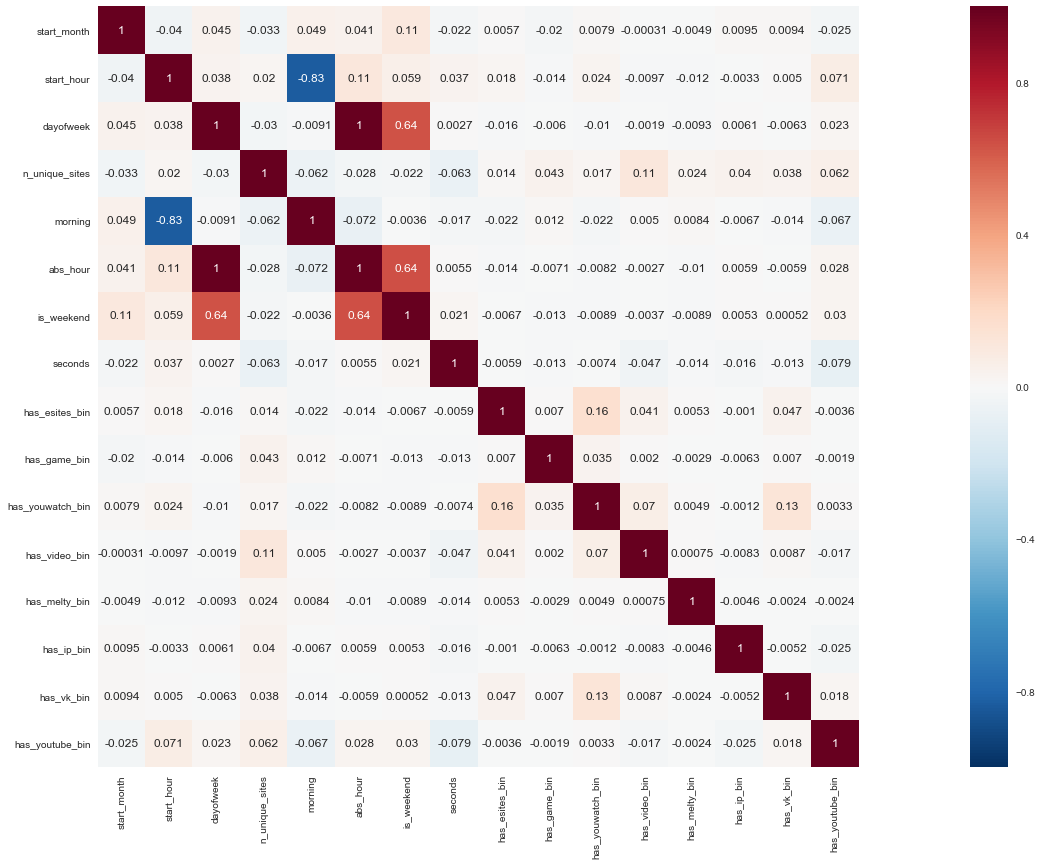

In [34]:
plt.figure(figsize=(40,14))
sns.heatmap(full_new_feat.corr(), square=True, annot=True);

In [33]:
def get_train_test(full_new_feat, X_ids, top_bin_columns, idx_split):
    
    tmp_scaled = StandardScaler().fit_transform(full_new_feat[['seconds', 'start_month']])
    
    X_full = csr_matrix(hstack([
                                X_ids,  
                                tmp_scaled, 
                                full_new_feat[top_bin_columns],
                                #full_new_feat[['morning']] 
                                # - strong negative correlation with start-hour - do not include
                                # а надо было! :-( на привате улучшило скор - wtf? корреляция же?..
                               ]))
    

    columns = ['dayofweek', 'start_hour']
    
    ohe = OneHotEncoder(sparse = True)
    for column in columns:
        encoded_features = ohe.fit_transform(full_new_feat[column].values.reshape(-1,1))[:,1:]

        X_full = csr_matrix(hstack([X_full, encoded_features]))
    
    return X_full[:idx_split,:], X_full[idx_split:,:]

Подберем оптимальный коэффициент регуляризации. В качестве кросс-валидации будем использовать не кастомную функцию *get_auc_lr_valid_time()*, а обертку над *cross_val_score()* с передачей индексов фолдов для валидации (просто для демонстрации, что этот механизм тоже работает).

In [15]:
# Подбор коэффицициента регуляризации
def get_best_C(X_train, y_train, plot = True):
    # набор возможных значений С
    Cs = np.logspace(-1, 2, 10)

    scores = []
    for C in Cs:
        auc = get_auc_lr_valid_idx(X_train, y_train, C=C)
        scores.append(auc)

    if plot:
        plt.plot(Cs, scores, 'ro-')
        plt.xscale('log')
        plt.xlabel('C')
        plt.ylabel('AUC-ROC')
        plt.title('Подбор коэффициента регуляризации')
        plt.show()

    CScores = list(zip(Cs, scores))
    CScores = sorted(CScores, key=lambda x: -x[1])
    best_C = CScores[0][0]
    
    return best_C, CScores[0][1]

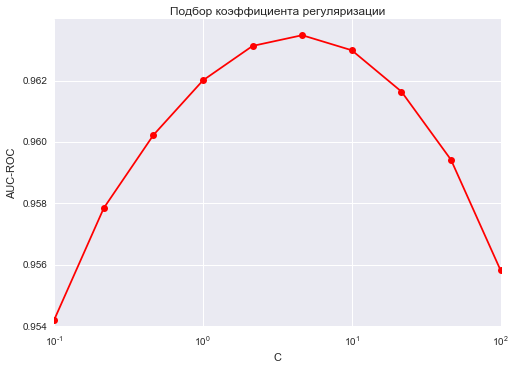

(4.6415888336127775, 0.96348210301490966)

In [18]:
#get_best_C(X_train, y_train)

In [16]:
# функция для записи прогнозов в файл
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)
    
    
def save_result(best_C, X_train, y_train, X_test, filename):
    # обучим модель на всей выборке с оптимальным коэффициентом регуляризации
    lr = LogisticRegression(C=best_C, random_state=17, n_jobs=-1).fit(X_train, y_train)

    # сделаем прогноз для тестовой выборки
    y_test = lr.predict_proba(X_test)[:, 1]

    # запишем его в файл, готовый для сабмита
    write_to_submission_file(y_test, filename)

## 6. Построение модели

Соберем итоговый пайплайн.

In [34]:
%%time

def make_pipeline(train_df, filename = 'ods_contest_identification.csv'):
    
    # 1. Preprocess data
    full_df, full_sites, y_train, idx_split = make_full_df(train_df)

    # 2. Make TF-IDF 
    texts = join_sites(full_sites)
    # 2.1 Search best params for TF-IDF
    #best_min_df, best_max_df = tune_tfidf_param(texts)
    #print(best_min_df, best_max_df)

    # 2.2 
    best_min_df = 25
    best_max_df = 0.09
    X_ids = calc_tfidf(texts, max_df=best_max_df, min_df = best_min_df)  
    #auc_mean, aucs = get_auc_lr_valid_time(X_ids[:idx_split,:], y_train, n_folds=5)
    #print(auc_mean)
    #print(aucs)    

    # 3. Make features
    full_new_feat, top_bin_columns = make_features(full_df)


    # 4. Split train\test
    X_train, X_test = get_train_test(full_new_feat, X_ids, top_bin_columns, idx_split)

    # 5. cross-validation score - uncomment to test
    #score_C_1, _ = get_auc_lr_valid_time(X_train, y_train, n_folds=5)
    score_C_1 = 0.962011568397
    print("Cross-val score: %f" % score_C_1)

    # 6. search best C and best score - uncomment to test
    #best_C, best_C_score = get_best_C(X_train, y_train, plot=False)
    best_C = 4.64158883361
    best_C_score = 0.963482218185
    print("Best C=%f; Best score=%f" % (best_C ,best_C_score))

    # save results
    save_result(best_C, X_train, y_train, X_test, filename)
    
    # return some variables for further investigation
    return X_train, y_train, best_C, full_new_feat
    
X_train, y_train, best_C, full_new_feat = make_pipeline(train_df) 

Cross-val score: 0.962012
Best C=4.641589; Best score=0.963482
Wall time: 3min 26s


## 7. Исследование модели

Чтобы каждый раз не сабмитить решение только для проверки стало оно хуже или лучше, необходимо как-то оценивать качество локально (лучше даже визуально). Будем строить кривые обучения и валидации, по примеру как в статье https://habrahabr.ru/company/ods/blog/323890/#5-krivye-validacii-i-obucheniya с небольшими доработками для LogisticRegression:

In [24]:
from sklearn.model_selection import validation_curve, learning_curve

def plot_with_err(x, data, xlog = False, **kwargs):
    mu, std = data.mean(1), data.std(1)
       
    if xlog:
        plt.xscale('log')
        
    lines = plt.plot(x, mu, 'o-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none', facecolor=lines[0].get_color(), alpha=0.2)

def plot_validation_curve(X, y):
    alphas = np.logspace(-2, 2, 10)

    idx = make_train_test_indices(X, 5)
    
    logit = LogisticRegression(n_jobs=-1, random_state=17)
    val_train, val_test = validation_curve(logit, X, y, 'C', alphas, cv=idx, scoring='roc_auc', n_jobs=-1)
    
    plot_with_err(alphas, val_train, xlog = True, label='training scores')
    plot_with_err(alphas, val_test, xlog = True, label='validation scores')
    plt.xlabel(r'С'); 
    plt.ylabel('ROC AUC')
    plt.legend();

def plot_learning_curve(X, y, C=1):
    train_sizes=[ 0.15, 0.33, 0.55, 0.78, 1.]
    
    idx = make_train_test_indices(X, 5)
    
    logit = LogisticRegression(C = C, n_jobs=-1, random_state=17)
    N_train, val_train, val_test = learning_curve(logit, X, y, cv=idx, scoring='roc_auc', n_jobs=-1,train_sizes=train_sizes)   
    
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); 
    plt.ylabel('AUC')
    plt.legend()

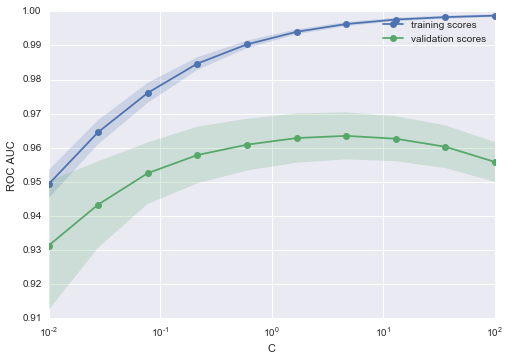

In [25]:
plot_validation_curve(X_train, y_train)

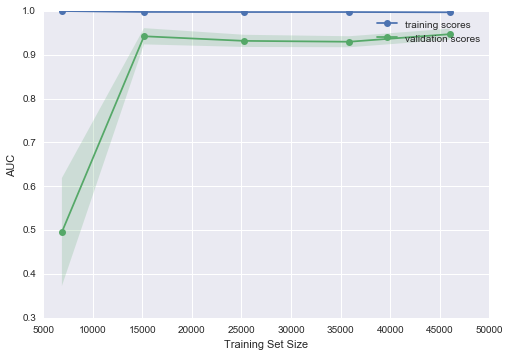

In [26]:
plot_learning_curve(X_train, y_train, C=best_C)

В качестве визуального контроля качества модели использовалась форма графиков, полученные выше. 

В процессе экспериментов были и другие варианты графиков, отличающиеся разбросом ошибки на валидационной кривой (соответственно, худшим скором на паблике). Например:

<center>
<img src="pic-cross-val-1.png">
</center>

<center>
<img src="pic-cross-val-2.png">
</center>

## Заключение

В процессе работы пришлось столкнуться со множеством не известных ранее проблем, подводных камней, а так же вариантами их решения. Очень помогли знания полученные из статей курса и домашних работ.

Однако, остался не решенным один вопрос. После открытия приватного рейтинга и прогонки некоторых вариантов решения, выяснилось, что коррелирующие признаки оказались весьма полезны и могли улучшить финальный рейтинг. **Вопрос - почему коррелирующие признаки улучшают значение метрики ROC-AUC?** Чуть ли не в каждой статье, где применяется логит пишут, что корреляция признаков не есть хорошо и надо исключать один (или несколько) из них. 

То же самое касается кодирования категориальных переменных с помощью *OneHotEncoder()* или *pandas.get_dummies()*, когда нужно делать N-1 колонку бинарных признаков для переменной (где N - количество классов категориальной переменной). Если **не следовать** этому правилу, то значение метрики ROC-AUC растет и скор на привате получался больше.

Ну и ложка дегтя с кастомной кросс-валидацией. Внезапно, после публикации приватного рейтинга пришла идея попробовать использовать не кастомную кросс-валидацию по времени, а стандартный сross_val_score() c разбиением по 5 фолдам без перемешивания. Удивительно, но рейтинг на привате получался абсолютно такой же, как и при использовании кастомной валидации :-) Так ли нужна была валидации по времени? Однако, не реализуй ее - не пришла бы идея усечь выборку и получить лучшее решение.  Вот так!